In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv

In [2]:
#To remove warnings
pd.options.mode.chained_assignment = None  # default='warn' 

# Summary

The main purpose of this notebook is to construct PARTNER x RELATION (RELTYPE) matrix using but050.csv & but051.csv. <br>
BUT050 contains the relationships between business partners (… is partner of …,  ... is child of..., etc).  <br> 
BUT051 contains contact person relationship: indicates what contact persons exist with for which organisation. <br>
A business partner can have multiple relations with many business partners (BUT050) including organizations (BUT051). <br>

The PARTNER x RELATION (RELTYPE) matrix can be used as features for classifying donors who donates only once to Leuven University Fund (LUF) and donors who donates more than once to LUF. <br>

BUT050 table contains both One-way relationship as well as Two-way relationship. <br>
The main features for BUT050 table are: <br>
-  PARTNER1: The source business partner
-  PARTNER2: The target business partner
-  RELTYPE: The type of relation between PARTNER1 & PARTNER2 <br>

The relationships used in BUT050 table is shown below. This is stored in TBZ9A table. <br>
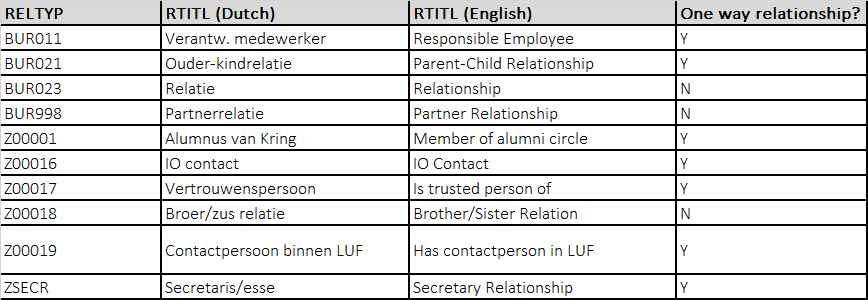

For the relationship types were the column ‘one way relationship’ indicates ‘Y’, the direction plays a role in the interpretation. <br>
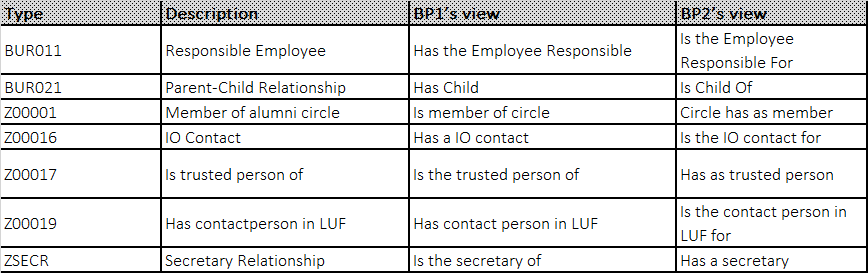

If for instance, in BUT050 there is an entry:<br>
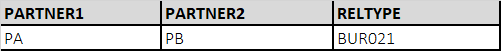 <br>
Then this means that PA is the parent of PB.<br>

Two way relations such as BUR023, BUR998, and Z00018 are normalized. Now all the relations between the business partners is One way. <br>

<br><br>BUT051 table contains only One-way relationship. <br>
There are only 2 features used in this table:
-  PARTNER1: Partner id of an organization.
-  PARTNER2: Partner id of a person.

The relation is read as PARTNER2 '… is contact person of …' PARTNER1. <br>
A business partner can be a contact person of multiple organizations. <br>
An organization can have multiple contact persons to LUF. <br>

In [3]:
but050 = pd.read_csv('sqldata/20190102_BUT050.csv',dtype = str, encoding='latin-1',sep=';')
but050['RELTYP'] = 'REL_' + but050['RELTYP']#Just to distinguish with RLTYP from but100
print(but050.shape)
but050.head()

(43435, 5)


,DATE_FROM,DATE_TO,PARTNER1,PARTNER2,RELTYP
0,1960.07.04,9999.12.31,0200025600,0200325734,REL_BUR021
1,1970.03.26,9999.12.31,0200025600,0200356884,REL_BUR021
2,1964.05.05,9999.12.31,0200025600,0200736210,REL_BUR021
3,0001.01.01,9999.12.31,0200000002,0200063069,REL_BUR011
4,0001.01.01,9999.12.31,0200000013,0200295958,REL_BUR011


We do not consider DATE_FROM and DATE_TO attribute. The reason is for some relations eg, BUR998 (Partner Relationship) the relationship is added to the database at the time of data migrations from the previous database. One such data migration happened in 2016.03.04. The results which is shown below gives a reason why it is not a good idea to consider 'DATE_FROM' and 'DATE_TO' attributes while generating features for the classifier. <br>
Another reason is 526 DATE_FROM have values '0001.01.01' which is clearly a faulty value.

In [4]:
but050['DATE_FROM'].value_counts()[:6]

2009.10.09    13767
2016.03.04    10091
2009.10.10     7461
2011.02.16     1307
2009.11.01     1025
0001.01.01      526
Name: DATE_FROM, dtype: int64

In [5]:
but050[but050['DATE_FROM']=='2016.03.04'].head()

,DATE_FROM,DATE_TO,PARTNER1,PARTNER2,RELTYP
8,2016.03.04,9999.12.31,0200000131,0201068139,REL_BUR998
15,2016.03.04,9999.12.31,0200000165,0201073391,REL_BUR998
17,2016.03.04,9999.12.31,0200000192,0201070861,REL_BUR998
23,2016.03.04,9999.12.31,0200000331,0201068158,REL_BUR998
26,2016.03.04,9999.12.31,0200000370,0201066118,REL_BUR998


In [6]:
but050['RELTYP'].value_counts()[:5]

REL_Z00001    26474
REL_BUR998    14645
REL_BUR021     1739
REL_BUR011      202
REL_Z00018      196
Name: RELTYP, dtype: int64

Most popular relationship in the database is 'REL_Z00001' which represents Partner 1 is a Member of Alumni circle (Partner 2). <br>
Let us see how many differnt alumni circles are there in the University.

In [7]:
print('Total number of members in all Alumni Circles: '+ str(len(set(but050['PARTNER1'][but050['RELTYP']=='REL_Z00001']))))
print('Number of Alumni Circles: '+ str(len(set(but050['PARTNER2'][but050['RELTYP']=='REL_Z00001']))))

Total number of members in all Alumni Circles: 16150
Number of Alumni Circles: 121


In [8]:
but051 = pd.read_csv('sqldata/20190102_BUT051.csv',dtype = str, encoding='latin-1',sep=';')
print(but051.shape)
but051.head()

(8726, 2)


,PARTNER1,PARTNER2
0,0201079167,0200006547
1,0201086231,0200007792
2,0200514562,0200014200
3,0201275282,0200038784
4,0201083814,0200056992


Let us check how many different organizations donate to LUF and how many contact persons there are for these organizations.

In [9]:
print('Number of Organizations: '+str(len(set(but051['PARTNER1']))))
print('Number of Contact Persons: '+str(len(set(but051['PARTNER2']))))

Number of Organizations: 7035
Number of Contact Persons: 8464


In [10]:
#Description of RELTYP
tbz9a = pd.read_csv('sqldata/20190102_TBZ9A.csv',dtype = str, encoding='latin-1',sep=';')
relation_des = tbz9a[['RELTYP','RTITL']][tbz9a['SPRAS']=='E']
relation_des.reset_index(drop=True,inplace=True)
relation_des #2 extra RELTYP are present in table namely 'BUR022' (Guardian Relationship) & 'BUR001' (Contact Person Rel.ship)

,RELTYP,RTITL
0,Z00001,Member of alumni circle
1,Z00016,IO Contact
2,Z00017,Is trusted person of
3,Z00019,Has contactperson in LUF
4,ZSECR,Secretary Relationship
5,BUR998,Partner Relationship
6,BUR001,Contact Person Rel.ship
7,BUR011,Responsible Employee
8,BUR021,Parent-Child Relationship
9,BUR022,Guardian Relationship


In [11]:
but050 = but050[['PARTNER1','PARTNER2','RELTYP']]
print(but050.shape)
but050.head()

(43435, 3)


,PARTNER1,PARTNER2,RELTYP
0,0200025600,0200325734,REL_BUR021
1,0200025600,0200356884,REL_BUR021
2,0200025600,0200736210,REL_BUR021
3,0200000002,0200063069,REL_BUR011
4,0200000013,0200295958,REL_BUR011


In [12]:
but051['RELTYP'] = 'REL_ORGCP'  #Create a dummy relationship so we can later concat but050 & but051 among these 3 columns
#ORGCP - Organization to Contact Person
print(but051.shape)
but051.head()

(8726, 3)


,PARTNER1,PARTNER2,RELTYP
0,0201079167,0200006547,REL_ORGCP
1,0201086231,0200007792,REL_ORGCP
2,0200514562,0200014200,REL_ORGCP
3,0201275282,0200038784,REL_ORGCP
4,0201083814,0200056992,REL_ORGCP


In [13]:
#Handlining 2 way relationship in but050
two_way_corr = but050[['PARTNER2','PARTNER1','RELTYP']][(but050['RELTYP']=='REL_BUR023') | (but050['RELTYP']=='REL_BUR998') | 
                                        (but050['RELTYP']=='REL_Z00018')]
two_way_corr = two_way_corr.rename(columns={"PARTNER2": "PARTNER1", "PARTNER1": "PARTNER2","RELTYP":"RELTYP"})
two_way_corr.reset_index(drop=True, inplace=True)
print(two_way_corr.shape)
two_way_corr.head()

(14894, 3)


,PARTNER1,PARTNER2,RELTYP
0,0201068139,0200000131,REL_BUR998
1,0200296033,0200000137,REL_BUR998
2,0200203952,0200000164,REL_BUR998
3,0201073391,0200000165,REL_BUR998
4,0201070861,0200000192,REL_BUR998


In [14]:
but050_2_way_corr = pd.concat([but050,two_way_corr])  #A<->B is same as B<->A
relations = pd.concat([but050_2_way_corr,but051])     #but050 + but051
print(relations.shape)
relations.head()

(67055, 3)


,PARTNER1,PARTNER2,RELTYP
0,0200025600,0200325734,REL_BUR021
1,0200025600,0200356884,REL_BUR021
2,0200025600,0200736210,REL_BUR021
3,0200000002,0200063069,REL_BUR011
4,0200000013,0200295958,REL_BUR011


In [15]:
relations_matrix = pd.crosstab(index = relations.iloc[:,0], columns = relations.iloc[:,2])
relations_matrix['PARTNER'] = relations_matrix.index
relations_matrix.reset_index(drop=True, inplace=True)
matrix_cols = ['PARTNER'] + ['REL_ORGCP'] + list(set(but050['RELTYP']))
relations_matrix = relations_matrix[matrix_cols]
print(relations_matrix.shape)
relations_matrix.head()

(47136, 12)


RELTYP,PARTNER,REL_ORGCP,REL_Z00016,REL_BUR998,REL_Z00001,REL_Z00018,REL_BUR011,REL_BUR023,REL_ZSECR,REL_BUR021,REL_Z00017,REL_Z00019
0,0200000002,0,0,0,0,0,1,0,0,0,0,0
1,0200000007,2,0,0,0,0,0,0,0,0,0,0
2,0200000013,1,0,0,0,0,1,0,0,0,0,0
3,0200000023,0,0,0,0,0,1,0,0,0,0,0
4,0200000035,2,0,0,0,0,1,0,0,0,0,0


In [16]:
#To cover for all possible business partners in the LUF database. Set the values for partners with no relations as 0
but000 = pd.read_csv('sqldata/20190102_BUT000.csv',dtype = str, encoding='latin-1',sep=';')
but000 = but000[['PARTNER']]
but000.shape

(72114, 1)

In [17]:
partner_rel_matrix = pd.merge(but000,relations_matrix,on='PARTNER',how='outer')
partner_rel_matrix = partner_rel_matrix.fillna(0)
partner_rel_matrix = partner_rel_matrix.sort_values(['PARTNER'], ascending=[1])
partner_rel_matrix.reset_index(drop=True, inplace=True)
rel_cols = ['REL_ORGCP'] + list(set(but050['RELTYP']))
sorted_rel_cols = ['PARTNER'] + ['REL_ORGCP'] + list(sorted(set(but050['RELTYP'])))
partner_rel_matrix[rel_cols] = partner_rel_matrix[rel_cols].astype('int')
partner_rel_matrix = partner_rel_matrix[sorted_rel_cols]
print(partner_rel_matrix.shape)
partner_rel_matrix.head()

(72638, 12)


,PARTNER,REL_ORGCP,REL_BUR011,REL_BUR021,REL_BUR023,REL_BUR998,REL_Z00001,REL_Z00016,REL_Z00017,REL_Z00018,REL_Z00019,REL_ZSECR
0,0200000002,0,1,0,0,0,0,0,0,0,0,0
1,0200000004,0,0,0,0,0,0,0,0,0,0,0
2,0200000005,0,0,0,0,0,0,0,0,0,0,0
3,0200000006,0,0,0,0,0,0,0,0,0,0,0
4,0200000007,2,0,0,0,0,0,0,0,0,0,0


In [18]:
#Write the relations matrix
partner_rel_matrix.to_csv('SQLDATA/PYTHON_OUTPUTS/Relations_p_r_matrix.csv')